In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.rcsetup
matplotlib.rcParams['figure.figsize'] = (15.0, 18.0)
matplotlib.rcParams['figure.dpi'] = 300
%matplotlib inline

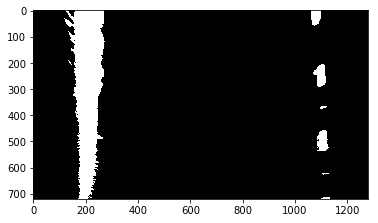

In [4]:
img = mpimg.imread('./doc_images/warp_mask_1.png')
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
height, width = img.shape
img = img > 0.01
plt.imshow(img, cmap='gray')

In [16]:
def polynomial_fit(img, show=False):
    '''Given a warped image return a polynomial that 
       describes the curvature of the lane line'''
    # Useful variables
    left_lane = LaneLine()
    right_lane = LaneLine()
    grey_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    height, width = grey_img.shape
    midpoint = np.int(width / 2)
    n_windows = 9
    window_height = np.int(height / n_windows)

    # Create binary image from img
    binary_img = np.zeros_like(grey_img)
    binary_img[grey_img > 0] = 1
    out_img = np.dstack((binary_img, binary_img, binary_img))#*255
    
    # Create histogram to find start of lane lines
    histogram = np.sum(binary_img[height//2:,:], axis=0)
    left_x_base = np.argmax(histogram[:midpoint])
    right_x_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Identify x,y positions of all nonzero pixels in the image
    nonzero = binary_img.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])
    
    left_x_current = left_x_base
    right_x_current = right_x_base
    margin = 100
    min_pix = 50
    
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(n_windows):
        win_y_low = height - (window + 1)*window_height
        win_y_high = height - window*window_height
        win_x_left_low   = left_x_current  - margin
        win_x_left_high  = left_x_current  + margin
        win_x_right_low  = right_x_current - margin
        win_x_right_high = right_x_current + margin
        cv2.rectangle(out_img,(win_x_left_low,  win_y_low), 
                              (win_x_left_high, win_y_high), 
                              (0, 1.0, 0), 5) 
        cv2.rectangle(out_img,(win_x_right_low, win_y_low),
                              (win_x_right_high,win_y_high),
                              (0, 1.0, 0), 5) 
        good_left_inds =  ((nonzero_y >= win_y_low) &
                           (nonzero_y <  win_y_high) &
                           (nonzero_x >= win_x_left_low) &
                           (nonzero_x <  win_x_left_high)).nonzero()[0]
        good_right_inds = ((nonzero_y >= win_y_low) &
                           (nonzero_y <  win_y_high) &
                           (nonzero_x >= win_x_right_low) &
                           (nonzero_x <  win_x_right_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        if len(good_left_inds) > min_pix:
            left_x_current = np.int(np.mean(nonzero_x[good_left_inds]))
        if len(good_right_inds) > min_pix:
            right_x_current = np.int(np.mean(nonzero_x[good_right_inds]))
    
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    left_x  = nonzero_x[left_lane_inds]
    left_y  = nonzero_y[left_lane_inds] 
    right_x = nonzero_x[right_lane_inds]
    right_y = nonzero_y[right_lane_inds]
    
    plot_y = np.linspace(0, height-1, height)
    overlay_l = np.copy(img)
    overlay_r = np.copy(img)
    overlay_c = np.copy(img)
    poly_img = np.copy(img)
    if left_x.sum() > 0  and left_y.sum() > 0:
        left_fit = np.polyfit(left_y, left_x, 2)
        left_fit_x = left_fit[0]*plot_y**2 + left_fit[1]*plot_y + left_fit[2]
        pts_l = np.column_stack((left_fit_x, plot_y)).astype(np.int32)
        cv2.polylines(overlay_l, [pts_l], False, (255, 0, 0), thickness=100, lineType=cv2.LINE_AA)
    else:
        print('No fit found, because no pixels found on left side')
        left_fit = None
        left_fit_x = None
        show = False
        
    if right_x.sum() > 0 and right_y.sum() > 0:
        right_fit = np.polyfit(right_y, right_x, 2)
        right_fit_x = right_fit[0]*plot_y**2 + right_fit[1]*plot_y + right_fit[2]
        pts_r = np.column_stack((right_fit_x, plot_y)).astype(np.int32)
        cv2.polylines(overlay_r, [pts_r], False, (0, 0, 255), thickness=100, lineType=cv2.LINE_AA)
    else:
        print('No fit found, because no pixels found on right side')
        right_fit = None
        right_fit_x = None
        show = False
    pts = np.concatenate((pts_l, pts_r[::-1]))
    cv2.fillPoly(overlay_c, np.int_([pts]), (0,255, 0))
    alpha = 0.5
    poly_img = cv2.addWeighted(overlay_l, alpha, poly_img, 1, 0)
    poly_img = cv2.addWeighted(overlay_r, alpha, poly_img, 1, 0)
    poly_img = cv2.addWeighted(overlay_c, alpha, poly_img, 1, 0)
    left_rad  = radius_curvature(left_fit_x,  plot_y)
    right_rad = radius_curvature(right_fit_x, plot_y)
    
    if show:
        print('Left Lane line  {0:.02}y^2 + {1:.02}y + {2:.02}'.format(left_fit[0], 
                                                                   left_fit[1],
                                                                   left_fit[2]))
        print('Left lane radius of curvature {0:.02} m'.format(left_rad))
        
        print('Right Lane line {0:.02}y^2 + {1:.02}y + {2:.02}'.format(right_fit[0], 
                                                                       right_fit[1],
                                                                       right_fit[2]))
        print('Right lane radius of curvature {0:.02} m'.format(right_rad))
        plt.imshow(poly_img)
#         plt.plot(left_fit_x,  plot_y, color='yellow')
#         plt.plot(right_fit_x, plot_y, color='yellow')
        
    return poly_img

In [5]:
def radius_curvature(x, y):
    y_scale = 30/720
    x_scale = 3.7/700
    
    x_fit = np.polyfit(y*y_scale, x*x_scale, 2)
    return ((1 + (2*x[0]*np.max(y)*y_scale + x[1])**2)**1.5) / np.absolute(2*x[0])

In [7]:
# Define a class to receive the characteristics of each line detection
class LaneLine():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_x_fitted = [] 
        #average x values of the fitted line over the last n iterations
        self.best_x = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.all_x = None  
        #y values for detected line pixels
        self.all_y = None

Left Lane line  -6e-05y^2 + 0.038y + 2e+02
Left lane radius of curvature 4.7e+09 m
Right Lane line -5.9e-05y^2 + 0.088y + 1.1e+03
Right lane radius of curvature 1.3e+11 m


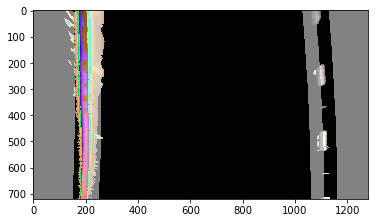

In [22]:
img = mpimg.imread('./doc_images/warp_mask_1.png')
final = polynomial_fit(img, show=True)